<a href="https://colab.research.google.com/github/sdelta/Practical_DL/blob/spring21/homework03/homework03_part1_both.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural networks for segmentation

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
!pip install albumentations segmentation_models_pytorch torchinfo opencv-python torchmetrics GPUtil
!pip uninstall -y opencv-python
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Successfully uninstalled opencv-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [2]:
#!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
#!unzip -q data.zip


In [3]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

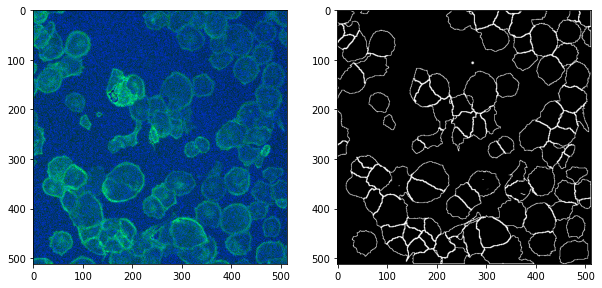

In [4]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [5]:
im = skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
im.dtype

dtype('uint8')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss. You also can try to use softIoU or DICE loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

### Initialize structures for saving results of training

In [6]:
import datetime
import tempfile
import random
import string
from os import path

# printing lowercase
letters = string.ascii_lowercase
print (  )

md_file_prefix = 'model_results_'

def get_temp_filename(name):
    result = None
    while result is None or path.exists(result):
        result =  name + '_' + ''.join(random.choice(letters) for i in range(5))
    return result

class ModelResults(object):
    def __init__(self, name):
        self.name = name
        self.timestamp = datetime.datetime.now()
        self.model_filename = get_temp_filename('models/' + name)
        self.comment = ''
        self.descr = ''
        self.params = {}
        self.stats = {}

### Describe model params

In [7]:
md = ModelResults('mobile_net_v3')
md.params = {
    'batch_size': 32,
    'lr': 0.0001,
    'optim': 'Adam'
}
md.comment = 'mobile_nev_v2 variation with data augmentation x100'

## Model and training definition

In [8]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [9]:
torch.cuda.empty_cache()

In [10]:
import segmentation_models_pytorch as smp

ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
    in_channels=3
).to(DEVICE)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
from torchinfo import summary

#md.descr = str(model)
#print(model)
summary(model)
#summary(model, (128, 3, 3, 3))

Layer (type:depth-idx)                                  Param #
FPN                                                     --
├─MobileNetV2Encoder: 1-1                               --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2dNormActivation: 3-1                   928
│    │    └─InvertedResidual: 3-2                       896
│    │    └─InvertedResidual: 3-3                       5,136
│    │    └─InvertedResidual: 3-4                       8,832
│    │    └─InvertedResidual: 3-5                       10,000
│    │    └─InvertedResidual: 3-6                       14,848
│    │    └─InvertedResidual: 3-7                       14,848
│    │    └─InvertedResidual: 3-8                       21,056
│    │    └─InvertedResidual: 3-9                       54,272
│    │    └─InvertedResidual: 3-10                      54,272
│    │    └─InvertedResidual: 3-11                      54,272
│    │    └─InvertedResidual: 3-12                      66,624
│    │    └

### Augment dataset

In [12]:
import os
import numpy as np

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms

images_dir = 'BBBC018_v1_images-fixed'
outlines_dir = 'BBBC018_v1_outlines'

In [13]:
import cv2

os.listdir(outlines_dir + '/train')[:5]
img=cv2.imread(outlines_dir + '/train/13571-cells.png')

In [14]:
images_lst = sorted(os.listdir(images_dir + '/train'))
outlines_lst = sorted(os.listdir(outlines_dir + '/train'))

print(images_lst[:5])
print(outlines_lst[:5])

['00735-actin.DIB.bmp', '00736-actin.DIB.bmp', '03997-actin.DIB.bmp', '03998-actin.DIB.bmp', '03999-actin.DIB.bmp']
['00735-cells.png', '00736-cells.png', '03997-cells.png', '03998-cells.png', '03999-cells.png']


In [15]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.geometric.transforms.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


class Augmentation(object):
    def __init__(self, aug_coef):
        self.aug_coef = aug_coef
        self.transform = get_training_augmentation()
        
        
    def __call__(self, pair):
        img, mask = pair
        result = []
        for i in range(self.aug_coef):
            transformed = self.transform(image=img, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
            result.append((transformed_image, transformed_mask))
        return result
        

In [16]:
import torch.utils.data as data


class CellDataset(data.Dataset):
        def __init__(self, images_dir, outlines_dir, preprocess=lambda x: x, augment=lambda x: [x]):
            images_lst = set(os.listdir(images_dir))
            outlines_lst = set(os.listdir(outlines_dir))
            assert len(images_lst) == len(outlines_lst)
            self.data = []
            for img_name in images_lst:
                outline_path = self._get_outline_filename(img_name)
                image = skimage.io.imread(os.path.join(images_dir, img_name))
                mask = skimage.io.imread(os.path.join(outlines_dir, outline_path))
                
                #assert np.logical_and(mask > 0, mask < 255).sum() == 0, outline_path
                mask[mask > 0] = 1
                augmented = augment((image, mask))
                for img, mask in augmented:
                    img = torch.from_numpy(preprocess(img)).type(torch.FloatTensor).permute(2, 0, 1)
                    mask = torch.from_numpy(mask).type(torch.LongTensor)
                    self.data.append((img, mask))
        
        def __getitem__(self, ind: int):
            return self.data[ind]
        
        def __len__(self):
            return len(self.data)
        
        @staticmethod
        def _get_outline_filename(img_filename: str) -> str:
            suffix = '-actin.DIB.bmp'
            new_suffix = '-cells.png'
            assert img_filename.endswith(suffix)
            return img_filename[:-len(suffix)] + new_suffix

In [17]:
import random

random.seed(42)

In [18]:
train_dataset = CellDataset(
    images_dir + '/train', 
    outlines_dir + '/train'
)

print("Augmenting train")
aug_train_dataset = CellDataset(
    images_dir + '/train', 
    outlines_dir + '/train',
    preprocess=preprocessing_fn,
    augment=Augmentation(100)
)

val_dataset = CellDataset(
    images_dir + '/val', 
    outlines_dir + '/val',
    preprocess=preprocessing_fn,
)

print("Augmenting val")
aug_val_dataset = CellDataset(
    images_dir + '/val', 
    outlines_dir + '/val',
    preprocess=preprocessing_fn,
    augment=Augmentation(100)
)

Augmenting train


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1641: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


Augmenting val


In [19]:
img = aug_train_dataset[0][1]
img.dtype

torch.int64

Text(0.5, 1.0, 'Val mask')

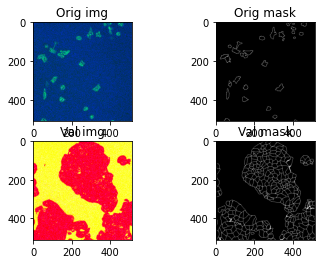

In [20]:
t_ind = 2
a_ind = 2




fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(train_dataset[t_ind][0].permute(1, 2, 0).numpy().astype('uint8'))
axs[0, 0].set_title('Orig img')
axs[0, 1].imshow(train_dataset[t_ind][1].numpy(), 'gray')
axs[0, 1].set_title('Orig mask')
axs[1, 0].imshow(val_dataset[a_ind][0].permute(1, 2, 0).numpy().astype('uint8'))
axs[1, 0].set_title('Val img')
axs[1, 1].imshow(val_dataset[a_ind][1].numpy(), 'gray')
axs[1, 1].set_title('Val mask')


In [21]:
print(len(aug_train_dataset))

4100


In [31]:
print(len(val_dataset))

7


In [22]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)
aug_train_batch_gen = torch.utils.data.DataLoader(aug_train_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)
aug_val_batch_gen = torch.utils.data.DataLoader(aug_val_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [23]:
def _calc_iou_inner(prediction, ground_truth, threshold=0.5):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > threshold, ground_truth[i] > threshold).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > threshold, ground_truth[i] > threshold).astype(np.float32).sum()
    return float(intersection) / union

#!L
def calc_iou(model, X_batch, y_batch, threshold=0.5):
    X_batch = torch.FloatTensor(X_batch).to(device=DEVICE)
    y_batch = torch.LongTensor(y_batch).to(device=DEVICE)
    result = model.to(DEVICE)(X_batch)
    return _calc_iou_inner(result.cpu().data.numpy(), y_batch.cpu().data.numpy(), threshold)

In [24]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.01, alpha=0.001):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        self.dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - self.dice

In [25]:
calc_loss = DiceLoss()

model.train(False) # enable dropout / batch_norm training behavior
for (X_batch, y_batch) in aug_val_batch_gen:
    break

print("X.shape = {}".format(X_batch.shape))
print("y.shape = {}".format(y_batch.shape))

# train on batch
y_pred = model(X_batch.to(DEVICE))
print("y_pred.shape = {}".format(y_pred.shape))

loss = calc_loss(y_pred, y_batch.to(DEVICE))
iou = _calc_iou_inner(y_pred.cpu().data.numpy(), y_batch.data.numpy())
print(loss)
print(iou)
#loss.backward()
#opt.step()
#opt.zero_grad()

X.shape = torch.Size([32, 3, 320, 320])
y.shape = torch.Size([32, 320, 320])
y_pred.shape = torch.Size([32, 1, 320, 320])
tensor(0.8890, device='cuda:0', grad_fn=<RsubBackward1>)
0.06237211350784238


Text(0.5, 1.0, 'pred mask')

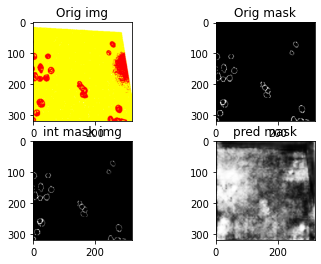

In [26]:
t_ind = 2
a_ind = 2

pred_numpy = y_pred[0][0].cpu().data.numpy()
intersection = y_batch[0].numpy() * pred_numpy


fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X_batch[0].permute(1, 2, 0).numpy().astype('uint8'))
axs[0, 0].set_title('Orig img')
axs[0, 1].imshow(y_batch[0].numpy(), 'gray')
axs[0, 1].set_title('Orig mask')
axs[1, 0].imshow(intersection, 'gray')
axs[1, 0].set_title('int mask img')
axs[1, 1].imshow(pred_numpy, 'gray')
axs[1, 1].set_title('pred mask')


In [27]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


### Training on minibatches
* We got 100k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [29]:
import numpy as np
from itertools import chain


batch_size = md.params['batch_size']

opt = getattr(torch.optim, md.params['optim'])(
    model.parameters(), 
    lr=md.params['lr']
)

train_loss = []
train_metric = []
val_iou_log = []
aug_val_iou_log = []
num_epochs = 35 # total amount of full passes over training data

calc_loss = DiceLoss()


best_epoch = 0
best_train_iou = -1
best_val_iou = -1


import time

start_counter = time.perf_counter()

try:
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in aug_train_batch_gen:
            # train on batch
            y_pred = model(X_batch.to(DEVICE))
            
            
            loss = calc_loss(y_pred, y_batch.to(DEVICE))
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())
            iou = _calc_iou_inner(y_pred.cpu().data.numpy(), y_batch.data.numpy())
            train_metric.append(iou)

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in aug_val_batch_gen:
            aug_val_iou_log.append(calc_iou(model, X_batch, y_batch))
        for X_batch, y_batch in val_batch_gen:
            val_iou_log.append(calc_iou(model, X_batch, y_batch))


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        train_acc = np.mean(train_loss[-len(train_dataset) // batch_size :])
        print("  training loss (in-iteration): \t{:.6f}".format(train_acc))
        train_iou = np.mean(train_metric[-len(train_dataset) // batch_size :])
        print("  training  IoU (in-iteration): \t{:.6f}".format(train_iou))
        aug_val_iou = np.mean(aug_val_iou_log[-len(val_dataset) // batch_size :])
        print("  aug validation IoU: \t\t\t{:.6f}".format(aug_val_iou))
        val_iou = np.mean(val_iou_log[-len(val_dataset) // batch_size :])
        print("  validation IoU: \t\t\t{:.6f}".format(val_iou))

        best_train_iou = train_iou
        if best_val_iou < val_iou:
            best_val_iou = val_iou
            best_epoch = epoch
            torch.save(model.state_dict(), md.model_filename)
finally:
    stop_counter = time.perf_counter()
    peak_ram = torch.cuda.max_memory_allocated()


Epoch 1 of 35 took 57.612s
  training loss (in-iteration): 	0.671423
  training  IoU (in-iteration): 	0.201223
  aug validation IoU: 			0.186505
  validation IoU: 			0.208076
Epoch 2 of 35 took 57.530s
  training loss (in-iteration): 	0.674960
  training  IoU (in-iteration): 	0.199751
  aug validation IoU: 			0.193933
  validation IoU: 			0.215832
Epoch 3 of 35 took 57.499s
  training loss (in-iteration): 	0.678673
  training  IoU (in-iteration): 	0.195719
  aug validation IoU: 			0.204613
  validation IoU: 			0.220103
Epoch 4 of 35 took 57.470s
  training loss (in-iteration): 	0.661753
  training  IoU (in-iteration): 	0.210431
  aug validation IoU: 			0.210029
  validation IoU: 			0.223932
Epoch 5 of 35 took 57.484s
  training loss (in-iteration): 	0.660538
  training  IoU (in-iteration): 	0.210710
  aug validation IoU: 			0.236132
  validation IoU: 			0.225456
Epoch 6 of 35 took 57.515s
  training loss (in-iteration): 	0.631037
  training  IoU (in-iteration): 	0.233208
  aug validati

KeyboardInterrupt: ignored

In [30]:
print(md.model_filename)

models/mobile_net_v3_sasov


In [58]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc 

gpu_usage()
#del X_batch
#del y_pred
#del result
#del opt
model = model.to("cpu")
gc.collect()
torch.cuda.empty_cache()
model = model.to("cuda:0")

gpu_usage()

| ID | GPU | MEM  |
-------------------
|  0 |  0% | 100% |
| ID | GPU | MEM |
------------------
|  0 | 54% |  9% |


In [90]:
from torchmetrics.functional import f1_score, precision, recall, accuracy
import pandas as pd

df = pd.DataFrame()
df.index.name = "threshold"

model.train(False) # disable dropout / use averages for batch_norm

for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
  c_df = pd.DataFrame()
  for X_batch, y_batch in val_batch_gen:
    X_batch = torch.FloatTensor(X_batch).to(device=DEVICE)
    y_batch = torch.LongTensor(y_batch).to(device=DEVICE)
    result = model.to(DEVICE)(X_batch)
    
    metrics = {
      "IoU": _calc_iou_inner(result.cpu().data.numpy(), y_batch.cpu().data.numpy(), threshold=threshold),
      "precision": precision(result, y_batch, threshold=threshold).cpu().data.numpy(),
      "recall": recall(result, y_batch, threshold=threshold).cpu().data.numpy(),
      "accuracy": accuracy(result, y_batch, threshold=threshold).cpu().data.numpy(),
      "f1": f1_score(result, y_batch, threshold=threshold).cpu().data.numpy(),
    }
    c_df = c_df.append(metrics, ignore_index=True)
  df.loc[threshold] = c_df.mean()
    
    


In [91]:
df

,IoU,precision,recall,accuracy,f1
threshold,,,,,
0.1,0.231195,0.256945,0.697603,0.877381,0.375562
0.2,0.234356,0.265602,0.665787,0.885027,0.379722
0.3,0.236068,0.271702,0.642848,0.890039,0.381965
0.4,0.237049,0.276784,0.622816,0.894043,0.383249
0.5,0.237666,0.281668,0.603392,0.897697,0.384055
0.6,0.237716,0.286602,0.582226,0.901313,0.38412
0.7,0.237264,0.292109,0.558245,0.905141,0.38353
0.8,0.23505,0.298363,0.525543,0.909595,0.380632
0.9,0.229748,0.308579,0.473499,0.91609,0.37365


In [ ]:
md.stats = {
    'total_epoch': epoch + 1,
    'total_time': stop_counter - start_counter,
    'peak_ram': peak_ram,
    'best_epoch': best_epoch,
    #'best_train_acc': best_train_acc,
    #'best_val_acc': best_val_acc,
    #'test_acc': test_accuracy
}
print(md.stats)

In [ ]:
import pickle

name = get_temp_filename('models_stats/' + md.name)
with open(name, 'wb') as fout:
    pickle.dump(md, fout)
with open('current_model_info', 'w') as fout:
    print('model file {}\nmodel stats {}'.format(md.model_filename, name), file=fout)
print('saved model stats in {}'.format(name))